In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
import math
from sklearn.decomposition import PCA
import torch.nn.functional as F
from sklearn.svm import SVC
import torch.optim as optim
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [3]:
df_test = pd.read_csv("Credit_card_datasets\credit_card_dataset_test.csv") 
df_train = pd.read_csv("Credit_card_datasets\credit_card_dataset_train.csv")

In [4]:
def performance_metrics(modelprediction, target):
    '''
    return accuracy and F1 score
    '''
    return accuracy_score(target, modelprediction), f1_score(target, modelprediction, average='weighted')

In [5]:
def display_confusion_matrix(modelprediction, target):
    '''
    plots the confusion matrix
    '''
    cm = confusion_matrix(target, modelprediction)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

Trivial System

In [130]:
import random
def assign_class(N0, N1, N):
    prob_0 = N0 / N
    prob_1 = N1 / N 
    rand_num = random.random()
    if rand_num < prob_0:
        return 0 
    else:
        return 1 
N0= 21028
N1=5972
N=27000
train_pred = []
test_pred = []
train_labels = df_train['default payment next month']
test_labels = df_test['default payment next month']
for i in range(27000):
    train_pred.append(assign_class(N0,N1,N))
for i in range(3000):
    test_pred.append(assign_class(N0,N1,N))
train_acc, train_f1 = performance_metrics(train_labels, train_pred)
test_acc, test_f1 = performance_metrics(test_labels, test_pred)

In [131]:
print(f'Training Accuracy : {train_acc*100} Train F1 Score {train_f1*100}')
print(f'Testing Accuracy : {test_acc*100} Testing F1 Score {test_f1*100}')

Training Accuracy : 65.78518518518518 Train F1 Score 65.89746584700428
Testing Accuracy : 64.7 Testing F1 Score 64.50493345843827


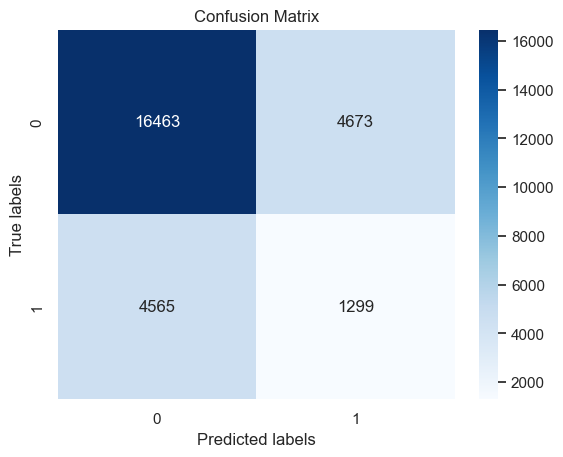

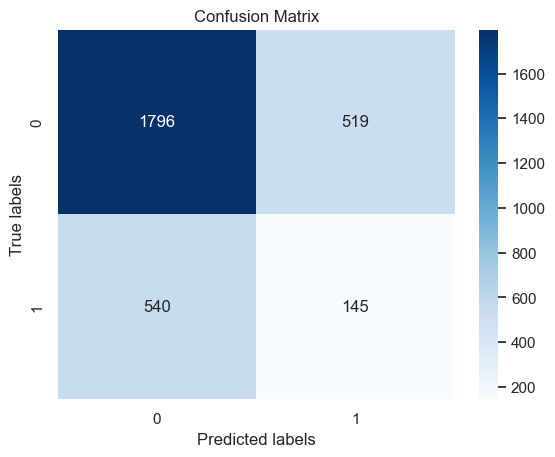

In [132]:
display_confusion_matrix(train_labels, train_pred)
display_confusion_matrix(test_labels, test_pred)

As we see above the training dataset has no null values.

In [6]:
def distribution(dataframe):
    '''
    Function to display the class distribution of the dataset
    '''
    label_counts = dataframe['default payment next month'].value_counts()
    sns.set()
    sns.set_palette("Paired")
    sns.set_style("whitegrid")
    plt.figure(figsize=(8,8))
    plt.pie(label_counts.values, labels=['No','Yes'], autopct='%1.1f%%')
    plt.title('Label Distribution')
    plt.show()

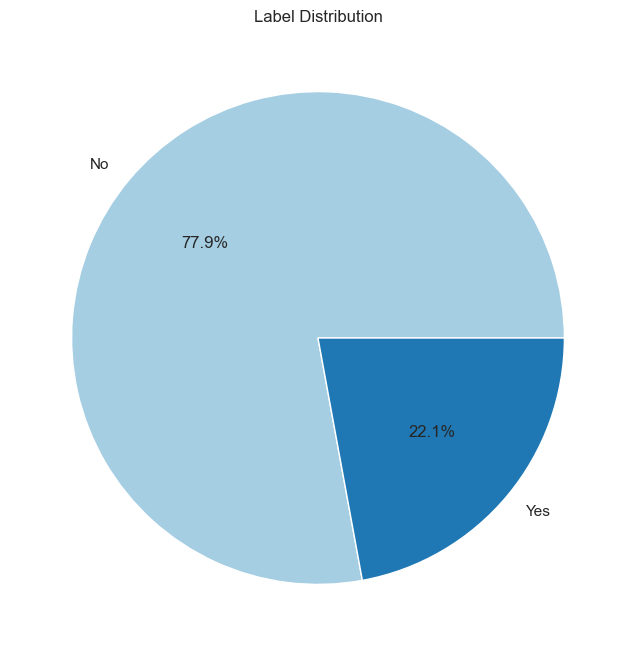

In [7]:
distribution(df_train)

In [8]:
def datacleaning(dataframe):
    dataframe['EDUCATION'] = dataframe['EDUCATION'].replace(0, 4)
    dataframe['EDUCATION'] = dataframe['EDUCATION'].replace(5, 4)
    dataframe['EDUCATION'] = dataframe['EDUCATION'].replace(6, 4)
    dataframe['MARRIAGE'] = dataframe['MARRIAGE'].replace(0, 3)
    pay_features = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
    bill_amt_features = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']
    for f in pay_features:
        condition1 = (dataframe[f] == -2) | (dataframe[f] == -1) | (dataframe[f] == 0) # checks if any of the values are -2, -1, or 0
        dataframe.loc[condition1, f] = 0
    for f in bill_amt_features:
        condition4 = (dataframe[f] < 0)  # checks if any of the values are < 0
        dataframe.loc[condition4, f] = 0
    return dataframe

In [9]:
df_train = datacleaning(df_train)
df_test = datacleaning(df_test)

In [10]:
def categorical_clean(dataframe):
    # checks if all pay_i values are 0 and default payment next month = 1 which is not possible
    condition2 = (dataframe[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] == 0).all(axis=1) & (dataframe['default payment next month'] == 1)
    dataframe = dataframe.loc[~condition2]
    # checks if all pay_i values > 0 and default payment next month = 0 which is not possible
    condition3 = (dataframe[['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']] > 0).all(axis=1) & (dataframe['default payment next month'] == 0)
    dataframe = dataframe.loc[~condition3]
    return dataframe

In [11]:
df_train = categorical_clean(df_train)

Removin outliers using Quantile Method

In [12]:
df_train = df_train[(df_train >= df_train.quantile(0.01)) & (df_train <= df_train.quantile(0.99))].dropna()

In [13]:
def datascaling_encoding(dataframe, encoded_flag = False):
    df_numerical = ['LIMIT_BAL','AGE', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                    'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5','PAY_AMT6']
    df_categorical = ['SEX','EDUCATION','MARRIAGE', 'PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6','default payment next month']
    scaler = StandardScaler()
    dataframe_copy = dataframe.copy(deep = True)
    dataframe_copy[df_numerical] = scaler.fit_transform(dataframe[df_numerical])
    scaled_encoded_dataset = pd.concat([dataframe_copy[df_numerical], dataframe_copy[df_categorical]], axis = 1)
    return scaled_encoded_dataset

In [14]:
df_train_scaled = datascaling_encoding(df_train)
df_test_scaled = datascaling_encoding(df_test)

In [142]:
def pearson(dataframe):
    '''
    Function to create a heatmap showing the correlation between all the features by using the Pearson correlation 
    '''
    plt.figure(figsize=(24,24))
    cor = dataframe.corr(method='pearson')
    ax = plt.axes()
    sns.heatmap(cor, annot=True, cmap="YlGnBu",ax=ax)
    plt.show()

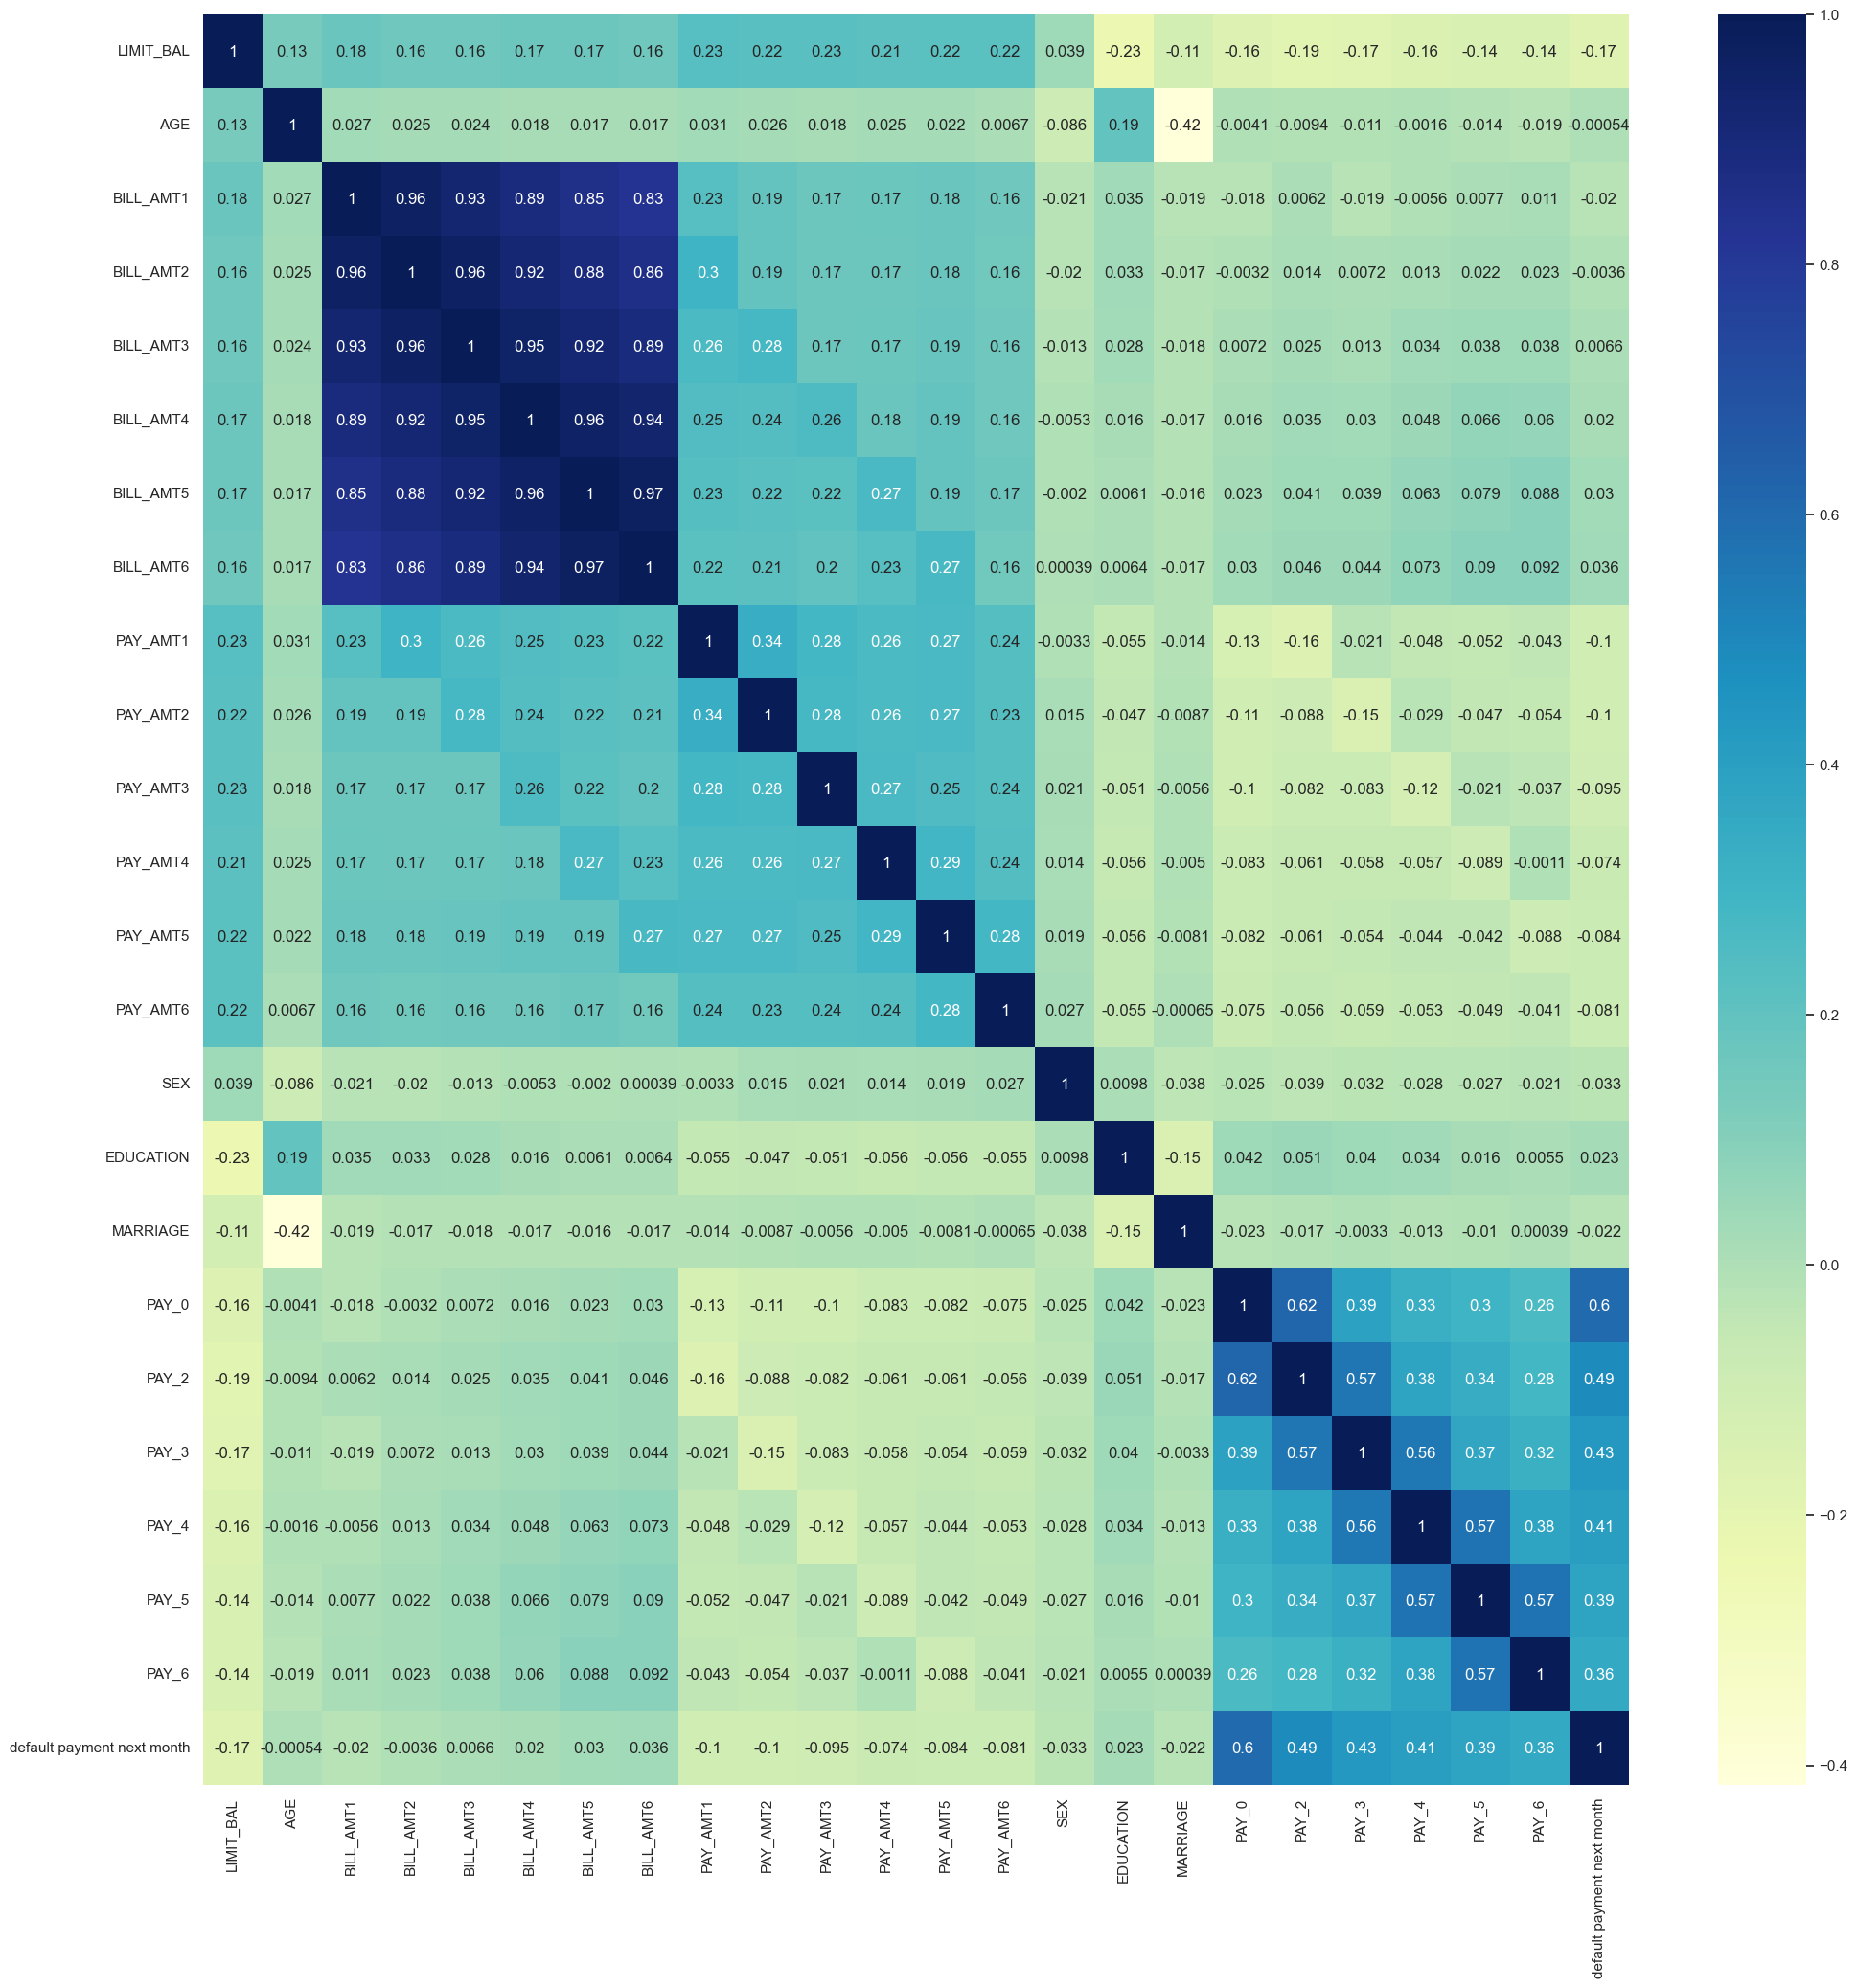

In [143]:
pearson(df_train_scaled)

In [144]:
#df_train_scaled = df_train_scaled.drop('BILL_AMT1', axis = 1)
#df_train_scaled = df_train_scaled.drop('BILL_AMT2', axis = 1)
#df_train_scaled = df_train_scaled.drop('BILL_AMT3', axis = 1)
#df_train_scaled = df_train_scaled.drop('PAY_AMT1', axis = 1)
#df_train_scaled = df_train_scaled.drop('PAY_AMT2', axis = 1)
#df_train_scaled = df_train_scaled.drop('PAY_AMT3', axis = 1)
#df_train_scaled = df_train_scaled.drop('PAY_0', axis = 1)
#df_train_scaled = df_train_scaled.drop('PAY_2', axis = 1)
#df_train_scaled = df_train_scaled.drop('PAY_3', axis = 1)

In [145]:
#df_test_scaled = df_test_scaled.drop('BILL_AMT1', axis = 1)
#df_test_scaled = df_test_scaled.drop('BILL_AMT2', axis = 1)
#df_test_scaled = df_test_scaled.drop('BILL_AMT3', axis = 1)
#df_test_scaled = df_test_scaled.drop('PAY_AMT1', axis = 1)
#df_test_scaled = df_test_scaled.drop('PAY_AMT2', axis = 1)
#df_test_scaled = df_test_scaled.drop('PAY_AMT3', axis = 1)
#df_test_scaled = df_test_scaled.drop('PAY_0', axis = 1)
#df_test_scaled = df_test_scaled.drop('PAY_2', axis = 1)
#df_test_scaled = df_test_scaled.drop('PAY_3', axis = 1)

In [146]:
def PCA_analysis(data):
    '''
    Function to perform feature analysis using PCA
    '''
    pca = PCA()
    pca.fit(data)
    components = np.arange(pca.n_components_) + 1
    plt.figure(figsize=(6,6))
    plt.plot(components, pca.explained_variance_ratio_.cumsum(), 'o-', linewidth=1, color='blue')
    plt.xlabel('Features')
    plt.ylabel('Variance')

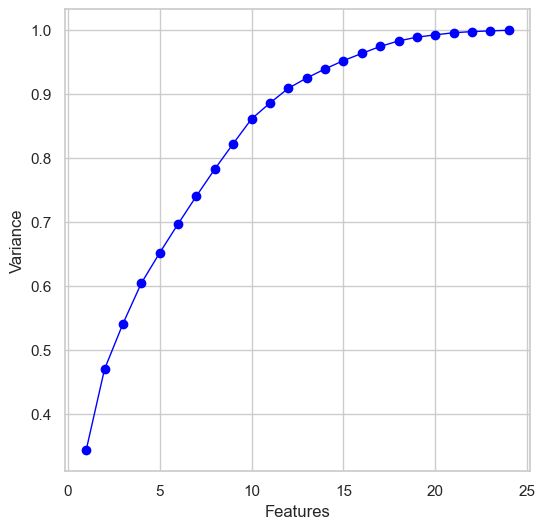

In [147]:
PCA_analysis(df_train_scaled)

In [15]:
def data_label(dataframe):
    '''
    return data and corresponding labels
    '''
    return dataframe.drop(['default payment next month'], axis = 1), dataframe['default payment next month'].copy(deep = True)

In [16]:
def performance_metrics(modelprediction, target):
    '''
    return accuracy and F1 score
    '''
    return accuracy_score(target, modelprediction), f1_score(target, modelprediction, average='weighted')

In [17]:
def display_confusion_matrix(modelprediction, target):
    '''
    plots the confusion matrix
    '''
    cm = confusion_matrix(target, modelprediction)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [18]:
def model_test(model, testdataframe, lda = None, LDA_flag = False):
    '''
    tests the model on the test data and reports the testing 
    metrics and confusion matrix
    '''
    data = testdataframe.drop(['default payment next month'], axis = 1)
    labels = testdataframe['default payment next month'].copy(deep = True)
    if LDA_flag == True:
        data = lda.transform(data)
    test_pred = model.predict(data)
    test_acc, test_f1 = performance_metrics(test_pred, labels)
    print(f"Testing Accuracy : {test_acc*100}")
    print(f"Testing F1 Score : {test_f1*100}")
    display_confusion_matrix(test_pred, labels)

Exploratory Data Analysis

In [24]:
df_numerical = df_train[['LIMIT_BAL','AGE', 'BILL_AMT1', 'BILL_AMT2','BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 
                    'PAY_AMT1','PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']]
df_categorical = df_train[['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']]

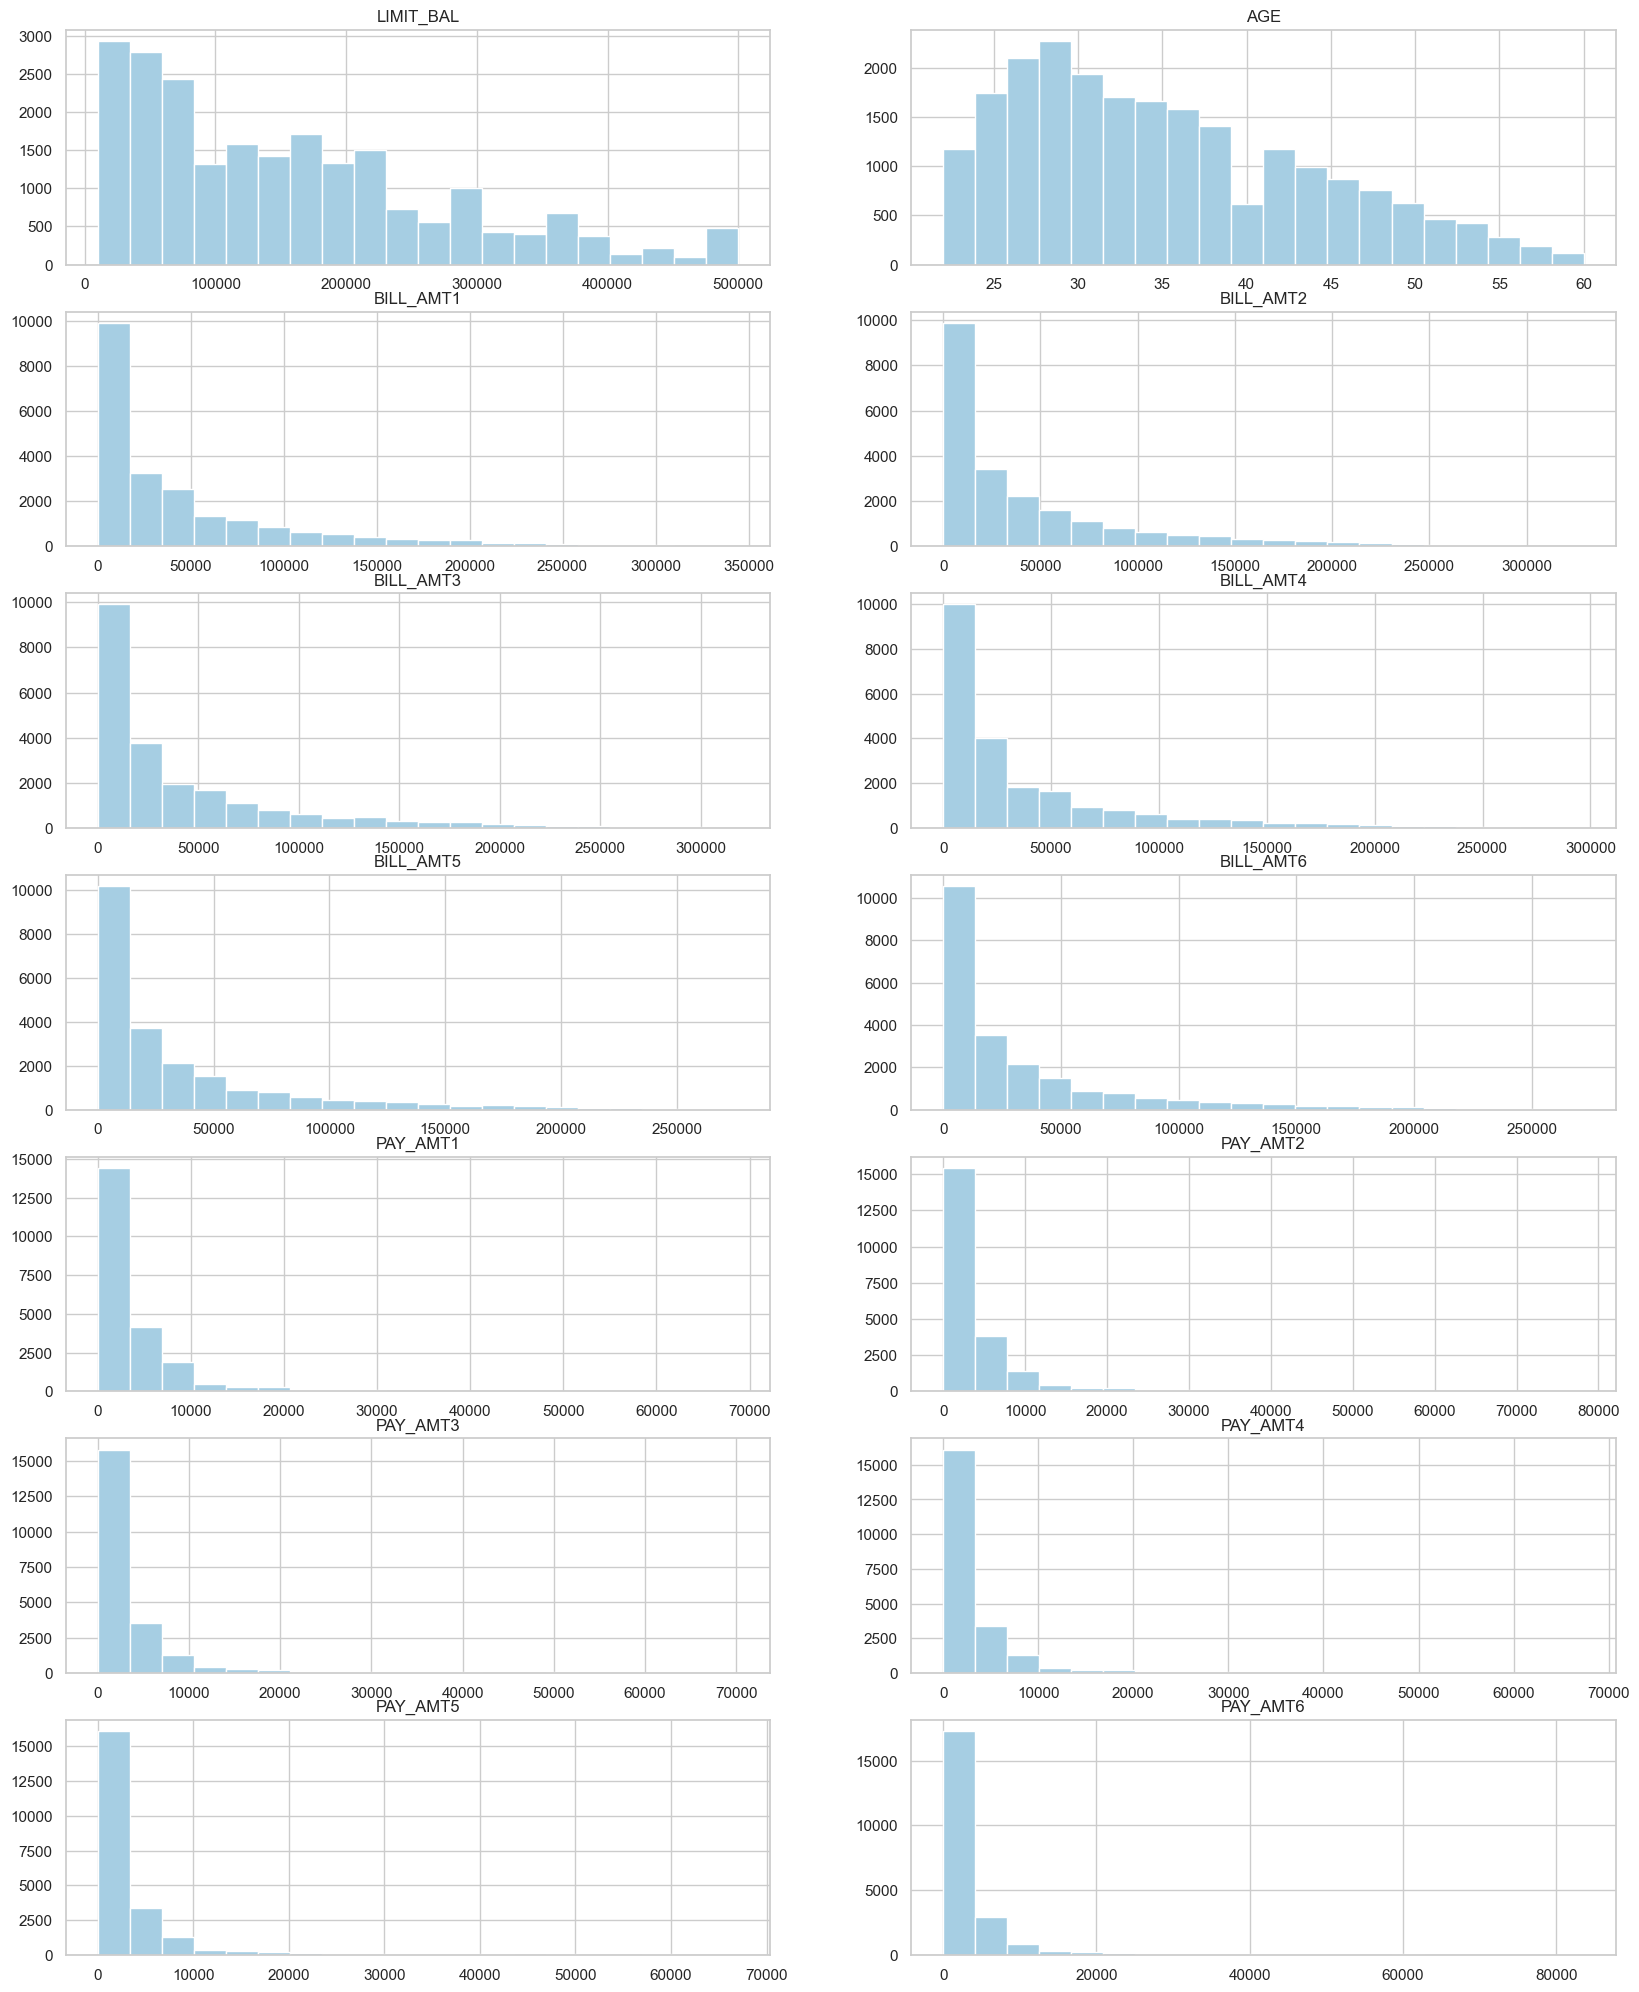

In [25]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 25))
for i, col in enumerate(df_numerical.columns):
    ax = axes[i//2, i%2]
    ax.hist(df_numerical[col], bins=20)
    ax.set_title(col)
plt.show()

We can see that the data is skewed requiring scaling

In [153]:
def percent(count, total_count, label):
    percentage = (count * 100) / total_count
    print("Percentage of {} is {}%".format(label, percentage))

Percentage of graduate school is 13.1511746680286%
Percentage of university is 16.204690831556505%
Percentage of high school is 17.25944306589468%
Percentage of others is 1.7341040462427746%


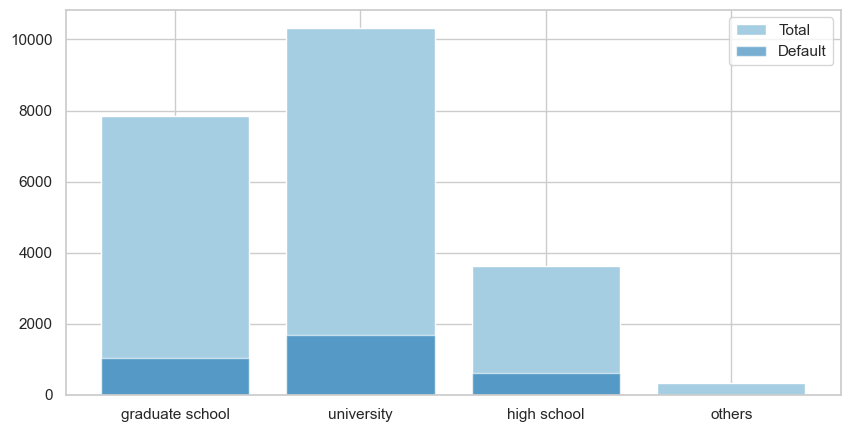

In [154]:
levels = [1, 2, 3, 4]
labels = ['graduate school', 'university', 'high school', 'others']
counts = [df_train['EDUCATION'][df_train['EDUCATION'] == level].count() for level in levels]
default_counts = [df_train['EDUCATION'][(df_train['EDUCATION'] == level) & (df_train['default payment next month'])].count() for level in levels]
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(levels, counts, label='Total')
ax.bar(levels, default_counts, alpha=0.6, label='Default')
ax.set_xticks(levels)
ax.set_xticklabels(labels)
ax.legend()
for label, count, default_count in zip(labels, counts, default_counts):
    percent(default_count, count, label)

Percentage of Married is 15.991943605236656%
Percentage of Single is 14.290509356381639%
Percentage of Other is 15.579710144927537%


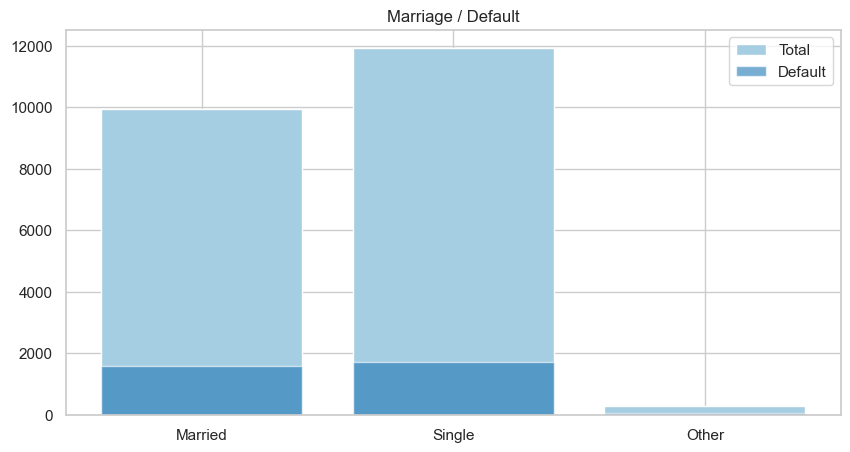

In [155]:
levels = [1, 2, 3]
labels = ['Married', 'Single', 'Other']
counts = [df_train['MARRIAGE'][df_train['MARRIAGE'] == level].count() for level in levels]
default_counts = [df_train['MARRIAGE'][(df_train['MARRIAGE'] == level) & (df_train['default payment next month'])].count() for level in levels]
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(levels, counts, label='Total')
ax.bar(levels, default_counts, alpha=0.6, label='Default')
ax.set_xticks(levels)
ax.set_xticklabels(labels)
ax.legend()
ax.set_title('Marriage / Default')
for count, default_count, label in zip(counts, default_counts, labels):
    percent(default_count, count, label)

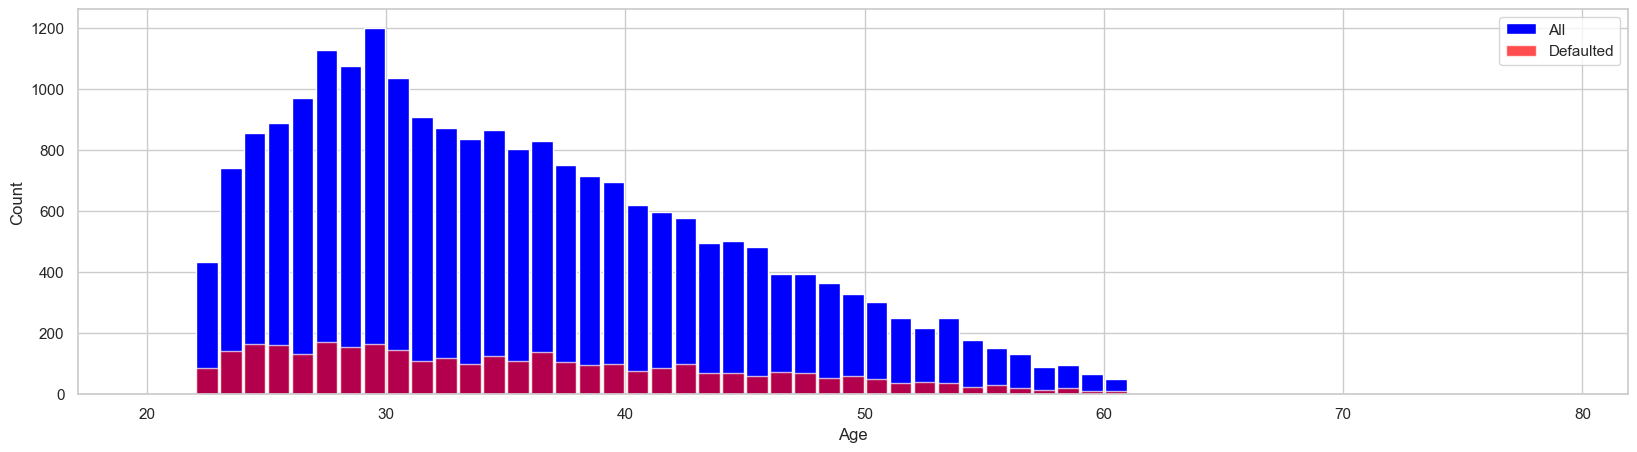

In [156]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.hist(df_train['AGE'], bins=range(20, 80, 1), rwidth=0.9, color='blue', label='All')
ax.hist(df_train['AGE'][df_train['default payment next month']==1], bins=range(20, 80, 1), rwidth=0.9, color='red', alpha=0.7, label='Defaulted')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.legend()

Baseline Model - Nearest Means Classifier

In [157]:
def baseline_nearest_means_train(dataframe, LDA_flag = False, n_comp = None):
    '''
    return the trained model and reports the training and
    validation metrics
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    if LDA_flag == True:
        lda = LinearDiscriminantAnalysis(n_components=n_comp)
        lda.fit(data, labels)
        data = lda.transform(data)
    model = NearestCentroid()
    X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val)
    train_acc, train_f1 = performance_metrics(train_pred, y_train)
    val_acc, val_f1 = performance_metrics(val_pred, y_val)
    print(f"Training Accuracy : {train_acc*100}")
    print(f"Training F1 Score : {train_f1*100}")
    print(f"Validation Accuracy : {val_acc*100}")
    print(f"Validation F1 Score : {val_f1*100}")
    if LDA_flag == True:
        return model, lda
    return model

Model on Scaled data

Training Accuracy : 87.6313707763589
Training F1 Score : 88.09392799409987
Validation Accuracy : 88.88135593220339
Validation F1 Score : 89.35342323425084
Testing Accuracy : 79.13333333333334
Testing F1 Score : 78.47403247172682


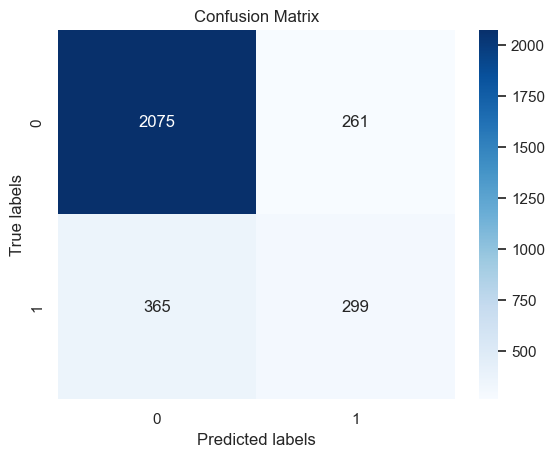

In [158]:
model = baseline_nearest_means_train(df_train_scaled)
model_test(model, df_test_scaled)

Model on Scaled data with LDA

Training Accuracy : 88.51847666402983
Training F1 Score : 88.86182443368725
Validation Accuracy : 89.22033898305085
Validation F1 Score : 89.65857857985787
Testing Accuracy : 80.56666666666666
Testing F1 Score : 79.82409015846093


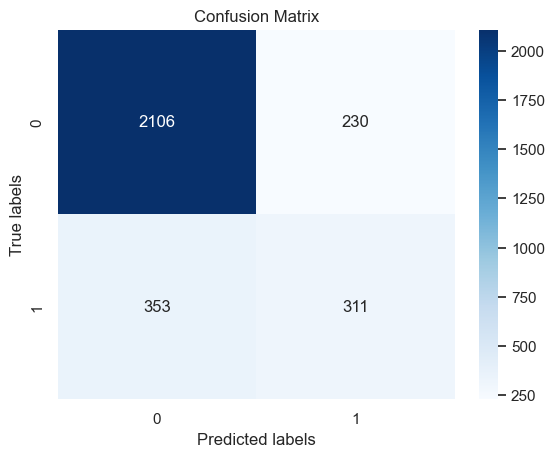

In [159]:
model, lda = baseline_nearest_means_train(df_train_scaled, LDA_flag=True)
model_test(model, df_test_scaled, lda=lda, LDA_flag=True)

Logistic Regression

In [160]:
def logistic_regression_tuning(dataframe, hyperparameters, LDA_flag = False, n_comp = None):
    '''
    Perform hyperparameter tuning for logistic regression and return the final trained model.
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    if LDA_flag == True:
        lda = LinearDiscriminantAnalysis(n_components=n_comp)
        lda.fit(data, labels)
        data = lda.transform(data)
    model = LogisticRegression()
    gridsearch = GridSearchCV(model, hyperparameters, cv=5, scoring='accuracy', n_jobs=-1)
    gridsearch.fit(data, labels)
    print("Best hyperparameters:", gridsearch.best_params_)
    model = LogisticRegression(**gridsearch.best_params_)
    if LDA_flag == True:
        return model, lda
    return model


In [189]:
def logistic_regression_train(dataframe, LDA_flag= False, n_comp = None):
    '''
    Training function for logistic regression
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    hyperparameters = {'penalty': ['l2'], 
                    'C': [100, 10, 1, 0.1, 0.01],
                    'solver': ['liblinear', 'newton-cg', 'lbfgs']}
    if LDA_flag == True:
        best_model, lda = logistic_regression_tuning(dataframe, hyperparameters, LDA_flag, n_comp)
        data = lda.transform(data)
    else:
        best_model = logistic_regression_tuning(dataframe, hyperparameters)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    if LDA_flag == True:
        data = data
    else:
        data = data.to_numpy()
    labels = labels.to_numpy()
    val_acc = 0
    val_f1 = 0
    for train_index, val_index in kf.split(data):
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        best_model.fit(X_train, y_train)
        v_acc, v_f1 = performance_metrics(y_val, best_model.predict(X_val))
        val_acc += v_acc
        val_f1 += v_f1
    train_pred = best_model.predict(data)
    train_acc, train_f1 = performance_metrics(train_pred, labels)
    print(f"Training Accuracy : {train_acc*100}")
    print(f"Training F1 Score : {train_f1*100}")
    print(f"Validation Accuracy : {(val_acc/5)*100}")
    print(f"Validation F1 Score : {(val_f1/5)*100}")
    display_confusion_matrix(train_pred, labels)
    if LDA_flag == True:
        return best_model, lda
    return best_model

Model with Scaled data

Best hyperparameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Training Accuracy : 89.84766984586177
Training F1 Score : 89.25459803747275
Validation Accuracy : 89.83410161318336
Validation F1 Score : 90.43128576661972


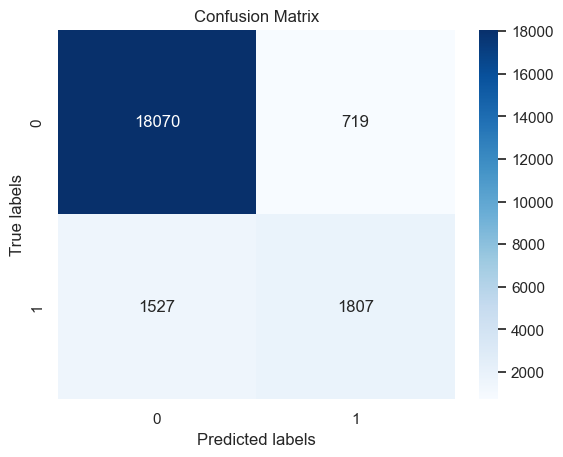

d:\anaconda3\envs\EE559\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Testing Accuracy : 81.53333333333333
Testing F1 Score : 79.37613806217281


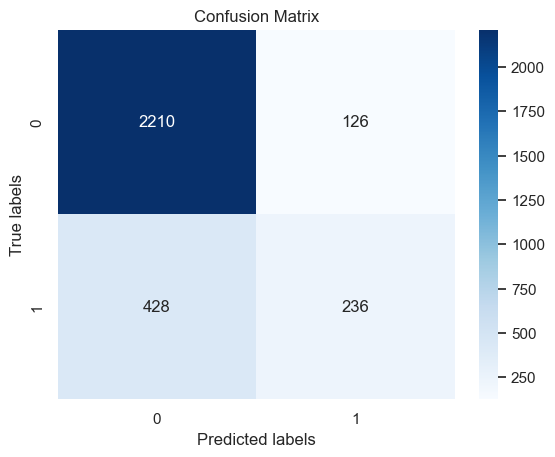

In [190]:
model = logistic_regression_train(df_train_scaled)
model_test(model, df_test_scaled)

Model with Scaled with LDA

Best hyperparameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
Training Accuracy : 89.97875514170772
Training F1 Score : 89.43435089601356
Validation Accuracy : 89.9877841460549
Validation F1 Score : 90.5238483708311


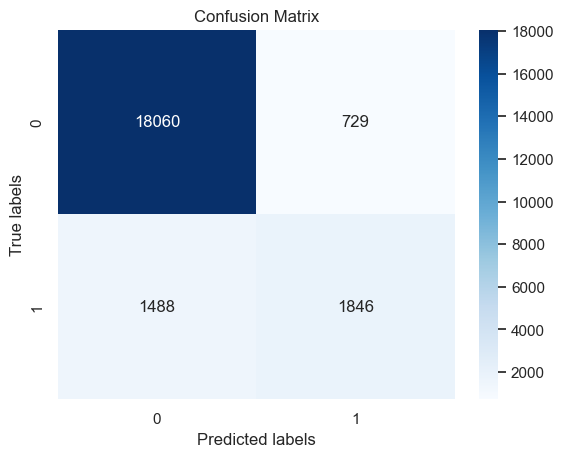

Testing Accuracy : 81.69999999999999
Testing F1 Score : 79.63041635296346


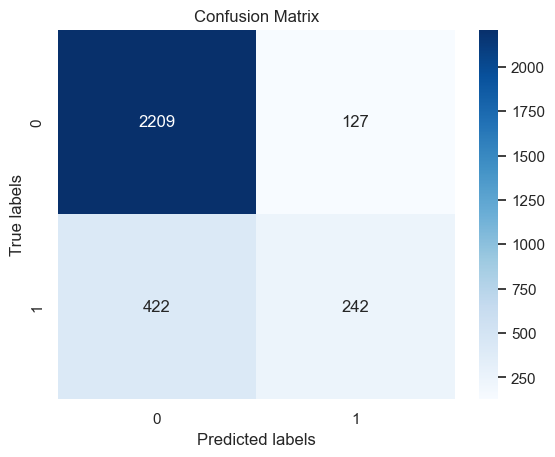

In [191]:
model, lda = logistic_regression_train(df_train_scaled, LDA_flag=True)
model_test(model, df_test_scaled, lda=lda, LDA_flag=True)

Support Vector Machines

In [19]:
def SVM_tuning(dataframe, hyperparameters, LDA_flag = False, n_comp = None):
    '''
    Perform hyperparameter tuning for support vector machines and return the final trained model.
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    if LDA_flag == True:
        lda = LinearDiscriminantAnalysis(n_components=n_comp)
        lda.fit(data, labels)
        data = lda.transform(data)
    model = SVC()
    gridsearch = GridSearchCV(model, hyperparameters, cv=5, scoring='accuracy', n_jobs=-1)
    gridsearch.fit(data, labels)
    print("Best hyperparameters:", gridsearch.best_params_)
    model = SVC(**gridsearch.best_params_)
    if LDA_flag == True:
        return model, lda
    return model

In [20]:
def SVM_train(dataframe, LDA_flag = False, n_comp = None):
    '''
    Training function for support vector machines
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    hyperparameters = {'kernel': ['linear', 'rbf'],
                    'gamma': [0.01, 1, 10],
                    'C': [0.1, 1, 100]}
    if LDA_flag == True:
        best_model, lda = SVM_tuning(dataframe, hyperparameters, LDA_flag, n_comp)
        data = lda.transform(data)
    else:
        best_model = SVM_tuning(dataframe, hyperparameters)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    if LDA_flag == True:
        data = data
    else:
        data = data.to_numpy()
    labels = labels.to_numpy()
    val_acc = 0
    val_f1 = 0
    for train_index, val_index in kf.split(data):
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        best_model.fit(X_train, y_train)
        v_acc, v_f1 = performance_metrics(y_val, best_model.predict(X_val))
        val_acc += v_acc
        val_f1 += v_f1
    train_pred = best_model.predict(data)
    train_acc, train_f1 = performance_metrics(train_pred, labels)
    print(f"Training Accuracy : {train_acc*100}")
    print(f"Training F1 Score : {train_f1*100}")
    print(f"Validation Accuracy : {(val_acc/5)*100}")
    print(f"Validation F1 Score : {(val_f1/5)*100}")
    display_confusion_matrix(train_pred, labels)
    if LDA_flag == True:
        return best_model, lda
    return best_model

Model with Scaled data

Best hyperparameters: {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}
Training Accuracy : 90.7517063689373
Training F1 Score : 90.12209027833308


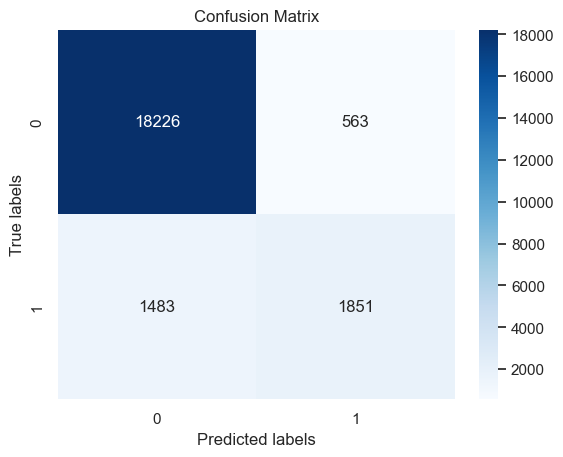

d:\anaconda3\envs\EE559\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Testing Accuracy : 81.83333333333334
Testing F1 Score : 79.8547846423284


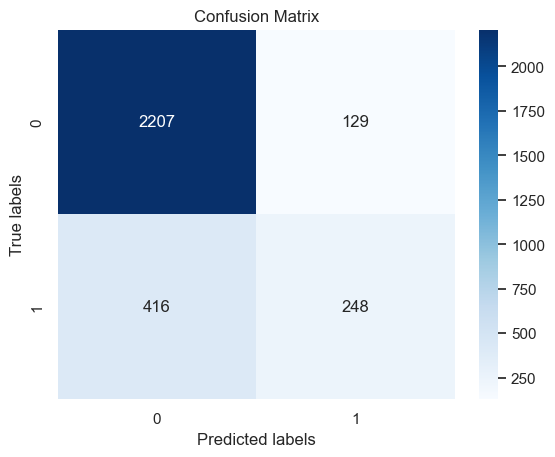

In [166]:
model = SVM_train(df_train_scaled)
model_test(model, df_test_scaled)

Model with Scaled data and LDA

Best hyperparameters: {'C': 100, 'gamma': 10, 'kernel': 'rbf'}
Training Accuracy : 90.06915879401528
Training F1 Score : 89.72813319358302
Validation Accuracy : 90.03299516760148
Validation F1 Score : 90.3737487067765


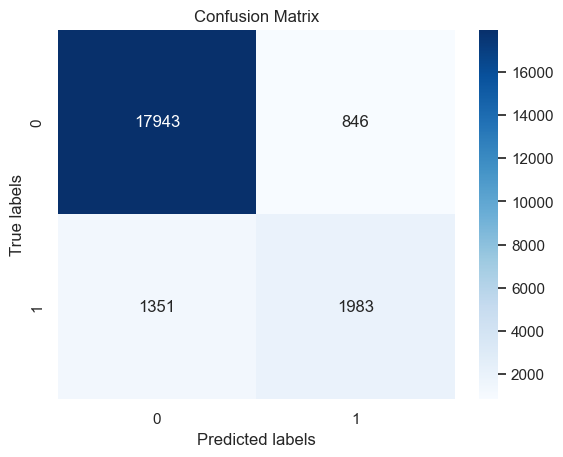

Testing Accuracy : 81.86666666666666
Testing F1 Score : 80.11972237411253


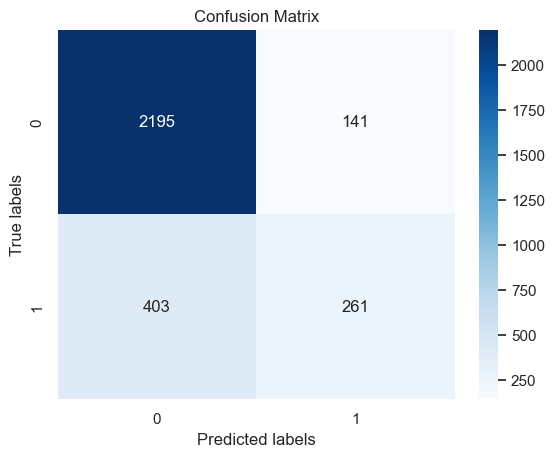

In [21]:
model, lda = SVM_train(df_train_scaled, LDA_flag=True)
model_test(model, df_test_scaled, lda=lda, LDA_flag=True)

use model_test for testing

K-Nearest Neighbors

In [168]:
def KNN_tuning(dataframe, hyperparameters, LDA_flag = False, n_comp = None):
    '''
    Perform hyperparameter tuning for k-nearest neighbors and return the final trained model.
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    if LDA_flag == True:
        lda = LinearDiscriminantAnalysis(n_components=n_comp)
        lda.fit(data, labels)
        data = lda.transform(data)
    model = KNeighborsClassifier()
    gridsearch = GridSearchCV(model, hyperparameters, cv=5, scoring='accuracy', n_jobs=-1)
    gridsearch.fit(data, labels)
    print("Best hyperparameters:", gridsearch.best_params_)
    model = KNeighborsClassifier(**gridsearch.best_params_)
    if LDA_flag == True:
        return model, lda
    return model

In [194]:
def KNN_train(dataframe, LDA_flag = False, n_comp = None):
    '''
    Training function for k-nearest neighbors
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    hyperparameters = {'n_neighbors': range(1, 50), 
                    'weights': ['uniform', 'distance']}
    if LDA_flag == True:
        best_model, lda = KNN_tuning(dataframe, hyperparameters, LDA_flag, n_comp)
        data = lda.transform(data)
    else:
        best_model = KNN_tuning(dataframe, hyperparameters)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    if LDA_flag == True:
        data = data
    else:
        data = data.to_numpy()
    labels = labels.to_numpy()
    val_acc = 0
    val_f1 = 0
    for train_index, val_index in kf.split(data):
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        best_model.fit(X_train, y_train)
        v_acc, v_f1 = performance_metrics(y_val, best_model.predict(X_val))
        val_acc += v_acc
        val_f1 += v_f1
    train_pred = best_model.predict(data)
    train_acc, train_f1 = performance_metrics(train_pred, labels)
    print(f"Training Accuracy : {train_acc*100}")
    print(f"Training F1 Score : {train_f1*100}")
    print(f"Validation Accuracy : {(val_acc/5)*100}")
    print(f"Validation F1 Score : {(val_f1/5)*100}")
    display_confusion_matrix(train_pred, labels)
    if LDA_flag == True:
        return best_model, lda
    return best_model

Model with Scaled Data

Best hyperparameters: {'n_neighbors': 35, 'weights': 'uniform'}
Training Accuracy : 89.88383130678478
Training F1 Score : 89.0264981131881
Validation Accuracy : 89.34139516351487
Validation F1 Score : 90.16788945395037


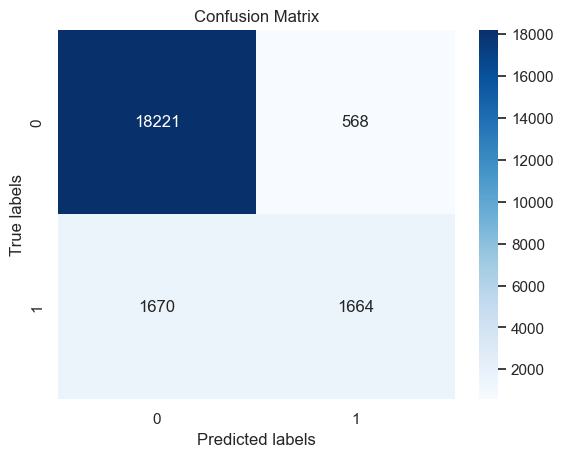

d:\anaconda3\envs\EE559\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Testing Accuracy : 80.9
Testing F1 Score : 78.46972923960477


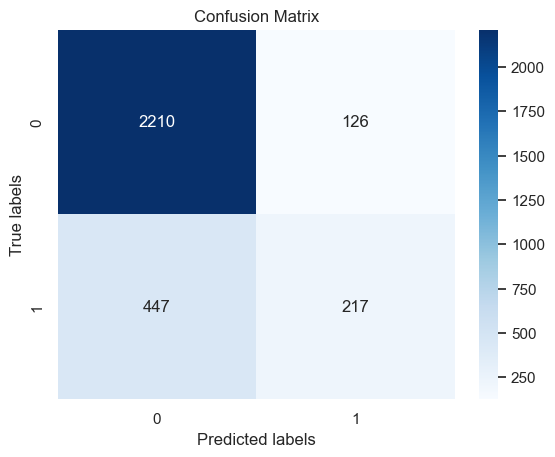

In [195]:
model = KNN_train(df_train_scaled)
model_test(model, df_test_scaled)

Model with Scaled data with LDA

Best hyperparameters: {'n_neighbors': 48, 'weights': 'uniform'}
Training Accuracy : 90.0465578809384
Training F1 Score : 89.37770023988811
Validation Accuracy : 89.85217560098488
Validation F1 Score : 90.45978788016404


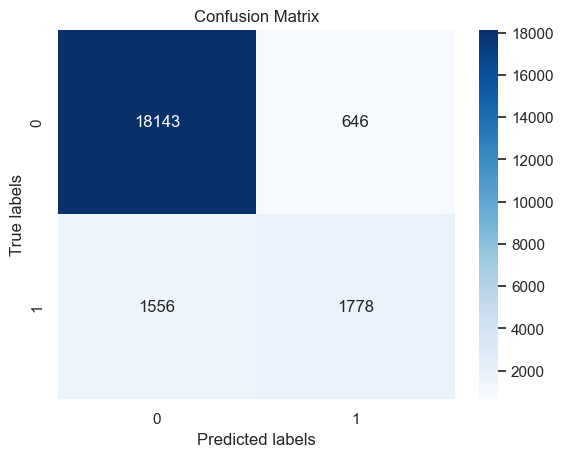

Testing Accuracy : 82.06666666666666
Testing F1 Score : 79.95249028670955


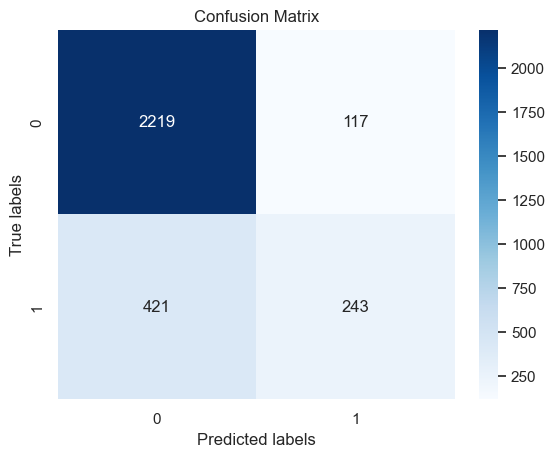

In [196]:
model, lda = KNN_train(df_train_scaled, LDA_flag=True)
model_test(model, df_test_scaled, lda=lda, LDA_flag=True)

Random Forest Classifier

In [197]:
def RF_tuning(dataframe, hyperparameters, LDA_flag = False, n_comp = None):
    '''
    Perform hyperparameter tuning for random forest classifier and return the final trained model.
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    if LDA_flag == True:
        lda = LinearDiscriminantAnalysis(n_components=n_comp)
        lda.fit(data, labels)
        data = lda.transform(data)
    model = RandomForestClassifier()
    gridsearch = GridSearchCV(model, hyperparameters, cv=5, scoring='accuracy', n_jobs=-1)
    gridsearch.fit(data, labels)
    print("Best hyperparameters:", gridsearch.best_params_)
    model = RandomForestClassifier(**gridsearch.best_params_)
    if LDA_flag == True:
        return model, lda
    return model

In [198]:
def RF_train(dataframe, LDA_flag = False, n_comp = None):
    '''
    Training function for random forest classifier
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    hyperparameters = {'max_depth': [5, 10, 20, None]}
    if LDA_flag == True:
        best_model, lda = RF_tuning(dataframe, hyperparameters, LDA_flag, n_comp)
        data = lda.transform(data)
    else:
        best_model = RF_tuning(dataframe, hyperparameters)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    if LDA_flag == True:
        data = data
    else:
        data = data.to_numpy()
    labels = labels.to_numpy()
    val_acc = 0
    val_f1 = 0
    for train_index, val_index in kf.split(data):
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        best_model.fit(X_train, y_train)
        v_acc, v_f1 = performance_metrics(y_val, best_model.predict(X_val))
        val_acc += v_acc
        val_f1 += v_f1
    train_pred = best_model.predict(data)
    train_acc, train_f1 = performance_metrics(train_pred, labels)
    print(f"Training Accuracy : {train_acc*100}")
    print(f"Training F1 Score : {train_f1*100}")
    print(f"Validation Accuracy : {(val_acc/5)*100}")
    print(f"Validation F1 Score : {(val_f1/5)*100}")
    display_confusion_matrix(train_pred, labels)
    if LDA_flag == True:
        return best_model, lda
    return best_model

Model with Scaled Data

Best hyperparameters: {'max_depth': 10}
Training Accuracy : 93.45477557293314
Training F1 Score : 93.03550137222523
Validation Accuracy : 89.92450526659923
Validation F1 Score : 90.64819735252854


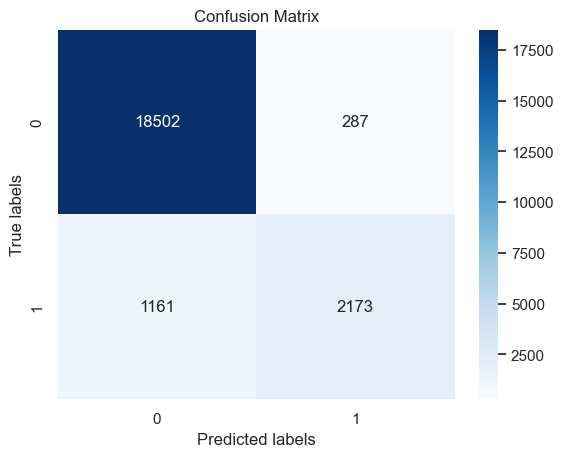

d:\anaconda3\envs\EE559\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Testing Accuracy : 81.76666666666667
Testing F1 Score : 79.32212457559191


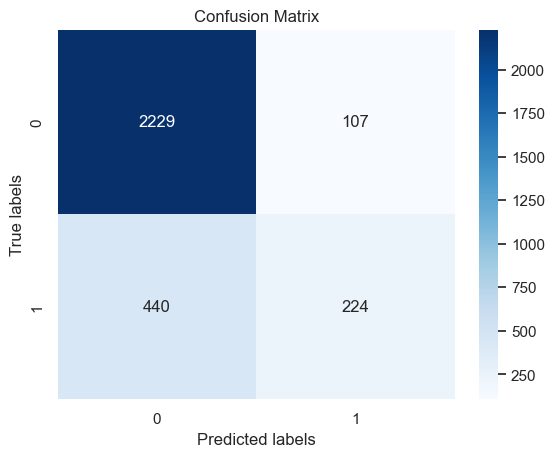

In [199]:
model = RF_train(df_train_scaled)
model_test(model, df_test_scaled)

Model with Scaled Data with LDA

Best hyperparameters: {'max_depth': 5}
Training Accuracy : 90.12792116801519
Training F1 Score : 89.75387659726297
Validation Accuracy : 90.00134551138628
Validation F1 Score : 90.39362737821251


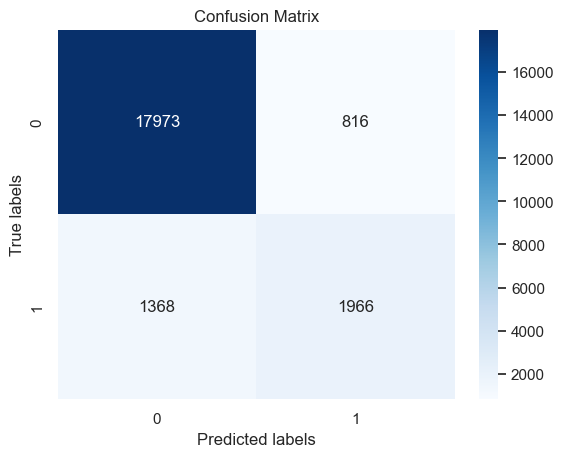

Testing Accuracy : 82.0
Testing F1 Score : 80.28344131878947


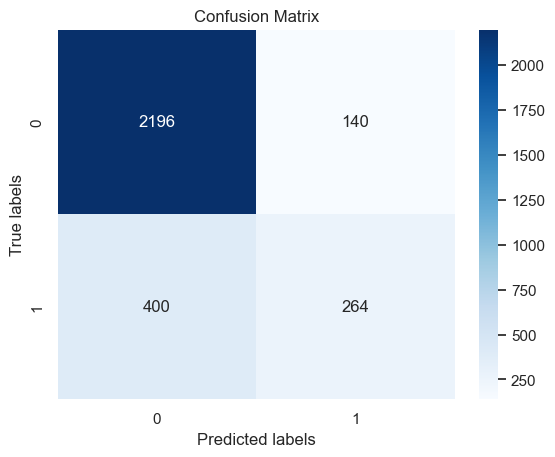

In [200]:
model, lda = RF_train(df_train_scaled, LDA_flag=True)
model_test(model, df_test_scaled, lda=lda, LDA_flag=True)

Artificial Nueral Network

In [201]:
train_data_scaled, train_label_scaled = data_label(df_train_scaled)
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_data_scaled, train_label_scaled, test_size=0.2, random_state=42)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
train_data_scaled_lda = lda.transform(X_train)
train_label_scaled = y_train
test_data_scaled_lda = lda.transform(X_val)
test_label_scaled = y_val

In [209]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_data = tf.constant(train_data_scaled_lda, dtype=tf.float32)
train_labels = tf.constant(train_label_scaled.values, dtype=tf.float32)
test_data = tf.constant(test_data_scaled_lda, dtype=tf.float32)
test_labels = tf.constant(test_label_scaled.values, dtype=tf.float32)

def make_model(lr=0.001, wd=0.01):
    model = keras.Sequential([
        layers.Dense(50, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=wd)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

def train_model(lr, wd):
    model = make_model(lr, wd)
    model.fit(train_data, train_labels, epochs=50, verbose=0)
    _, accuracy = model.evaluate(test_data, test_labels, verbose=0)
    return accuracy

param_grid = {"lr": [0.001, 0.01, 0.1, 1],
            "wd": [0.0, 0.01, 0.1]}
best_score = 0
best_params = {}
for lr in param_grid["lr"]:
    for wd in param_grid["wd"]:
        accuracy = train_model(lr, wd)
        if accuracy > best_score:
            best_score = accuracy
            best_params = {
                "lr": lr,
                "wd": wd,                    
            }
        print(f"learning Rate : {lr}, Weight Decay : {wd}, Validation Accuracy : {accuracy*100}")

print("Best: %f using %s" % (best_score, best_params))

learning Rate : 0.001, Weight Decay : 0.0, Validation Accuracy : 81.86666369438171
learning Rate : 0.001, Weight Decay : 0.01, Validation Accuracy : 81.83333277702332
learning Rate : 0.001, Weight Decay : 0.1, Validation Accuracy : 81.90000057220459
learning Rate : 0.01, Weight Decay : 0.0, Validation Accuracy : 81.90000057220459
learning Rate : 0.01, Weight Decay : 0.01, Validation Accuracy : 81.93333148956299
learning Rate : 0.01, Weight Decay : 0.1, Validation Accuracy : 81.83333277702332
learning Rate : 0.1, Weight Decay : 0.0, Validation Accuracy : 81.66666626930237
learning Rate : 0.1, Weight Decay : 0.01, Validation Accuracy : 81.16666674613953
learning Rate : 0.1, Weight Decay : 0.1, Validation Accuracy : 77.86666750907898
learning Rate : 1, Weight Decay : 0.0, Validation Accuracy : 71.36666774749756
learning Rate : 1, Weight Decay : 0.01, Validation Accuracy : 77.86666750907898
learning Rate : 1, Weight Decay : 0.1, Validation Accuracy : 77.86666750907898
Best: 0.819333 using 

In [210]:
train_data_scaled, train_label_scaled = data_label(df_train_scaled)
test_data_scaled, test_label_scaled = data_label(df_test_scaled)
lda = LinearDiscriminantAnalysis()
lda.fit(train_data_scaled, train_label_scaled)
train_data_scaled_lda = lda.transform(train_data_scaled)
train_label_scaled = train_label_scaled
test_data_scaled_lda = lda.transform(test_data_scaled)
test_label_scaled = test_label_scaled

139/139 [==============================] - 0s 2ms/step
Validation accuracy: 0.8973917365074158
Validation F1: 0.6241114487713741
94/94 [==============================] - 0s 2ms/step
Train accuracy : 0.9001491665840149
Train F1 : 0.6438819925842334


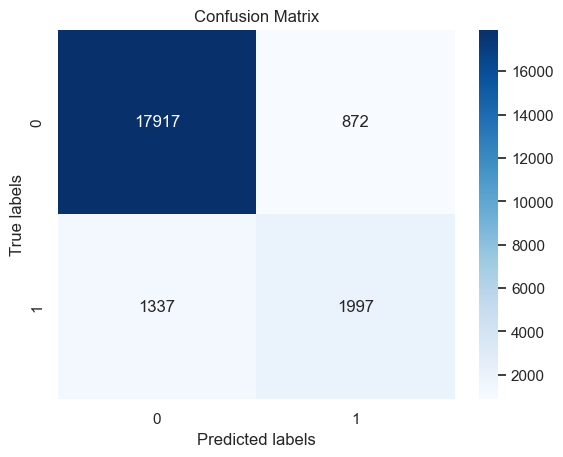

Test accuracy : 0.8190000057220459
Test F1 : 0.4948837209302326


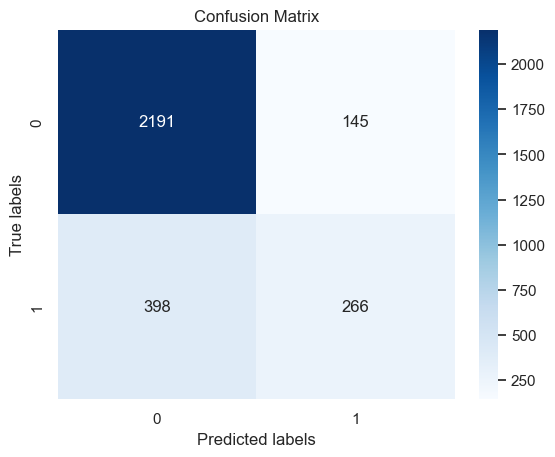

In [214]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

train_data = tf.constant(train_data_scaled_lda, dtype=tf.float32)
train_labels = tf.constant(train_label_scaled.values, dtype=tf.float32)
test_data = tf.constant(test_data_scaled_lda, dtype=tf.float32)
test_labels = tf.constant(test_label_scaled.values, dtype=tf.float32)

def make_model(lr=0.001, wd=0.01):
    model = keras.Sequential([
        layers.Dense(50, activation='relu', kernel_regularizer=keras.regularizers.L2(l2=wd)),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return model

def train_model(lr, wd):
    model = make_model(lr, wd)
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    train_accuracies, train_f1s, val_accuracies, val_f1s = [], [], [], []
    for train_index, val_index in kfold.split(train_data):
        X_train, X_val = tf.gather(train_data, train_index), tf.gather(train_data, val_index)
        y_train, y_val = tf.gather(train_labels, train_index), tf.gather(train_labels, val_index)
        model.fit(X_train, y_train, epochs=50, verbose=0)
        _, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
        train_pred = model.predict(X_train)
        train_pred = (train_pred > 0.5).astype(int)
        train_f1 = f1_score(train_pred, y_train)
        train_accuracies.append(train_accuracy)
        train_f1s.append(train_f1)
        _, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
        val_pred = model.predict(X_val)
        val_pred = (val_pred > 0.5).astype(int)
        val_f1 = f1_score(val_pred, y_val)
        val_accuracies.append(val_accuracy)
        val_f1s.append(val_f1)
    print(f'Validation accuracy: {np.mean(val_accuracies)}')
    print(f'Validation F1: {np.mean(val_f1s)}')
    model = make_model(lr, wd)
    model.fit(train_data, train_labels, epochs=50, verbose=0)
    _, test_accuracy = model.evaluate(test_data, test_labels, verbose=0)
    _, train_accuracy = model.evaluate(train_data, train_labels, verbose=0)
    train_pred = model.predict(train_data)
    train_pred = (train_pred > 0.5).astype(int)
    train_f1 = f1_score(train_pred, train_labels)
    y_pred = model.predict(test_data)
    y_pred = (y_pred > 0.5).astype(int)
    test_f1 = f1_score(test_labels, y_pred)
    print(f'Train accuracy : {train_accuracy}')
    print(f'Train F1 : {train_f1}')
    display_confusion_matrix(train_pred, train_labels)
    print(f'Test accuracy : {test_accuracy}')
    print(f'Test F1 : {test_f1}')
    display_confusion_matrix(y_pred, test_labels)

train_model(0.01, 0.01)

use model_test for testing

Naive Bayes 

In [215]:
def NB_tuning(dataframe, hyperparameters, LDA_flag = False, n_comp = None):
    '''
    Perform hyperparameter tuning for Naive Bayes classifier and return the final trained model.
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    if LDA_flag == True:
        lda = LinearDiscriminantAnalysis(n_components=n_comp)
        lda.fit(data, labels)
        data = lda.transform(data)
    model = GaussianNB()
    gridsearch = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=5, n_jobs=-1)
    gridsearch.fit(data, labels)
    print("Best hyperparameters:", gridsearch.best_params_)
    print("Best Model : ",gridsearch.best_estimator_)
    model = gridsearch.best_estimator_
    if LDA_flag == True:
        return model, lda
    return model

In [216]:
def NB_train(dataframe, LDA_flag = False, n_comp = None):
    '''
    Training function for random forest classifier
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    hyperparameters = {'var_smoothing': [1e-30, 1e-20, 1e-15, 1e-10, 1e-5, 1, 1e+5]}
    if LDA_flag == True:
        best_model, lda = NB_tuning(dataframe, hyperparameters, LDA_flag, n_comp)
        data = lda.transform(data)
    else:
        best_model = NB_tuning(dataframe, hyperparameters)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    if LDA_flag == True:
        data = data
    else:
        data = data.to_numpy()
    labels = labels.to_numpy()
    val_acc = 0
    val_f1 = 0
    for train_index, val_index in kf.split(data):
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        best_model.fit(X_train, y_train)
        v_acc, v_f1 = performance_metrics(y_val, best_model.predict(X_val))
        val_acc += v_acc
        val_f1 += v_f1
    train_pred = best_model.predict(data)
    train_acc, train_f1 = performance_metrics(train_pred, labels)
    print(f"Training Accuracy : {train_acc*100}")
    print(f"Training F1 Score : {train_f1*100}")
    print(f"Validation Accuracy : {(val_acc/5)*100}")
    print(f"Validation F1 Score : {(val_f1/5)*100}")
    display_confusion_matrix(train_pred, labels)
    if LDA_flag == True:
        return best_model, lda
    return best_model

Best hyperparameters: {'var_smoothing': 1}
Best Model :  GaussianNB(var_smoothing=1)
Training Accuracy : 88.74474528770962
Training F1 Score : 88.196656658908
Validation Accuracy : 88.75379184928637
Validation F1 Score : 89.29199045743698


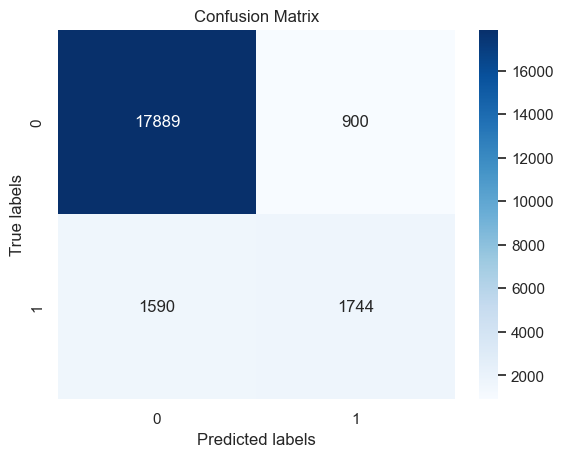

d:\anaconda3\envs\EE559\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


Testing Accuracy : 80.83333333333333
Testing F1 Score : 78.93976383064081


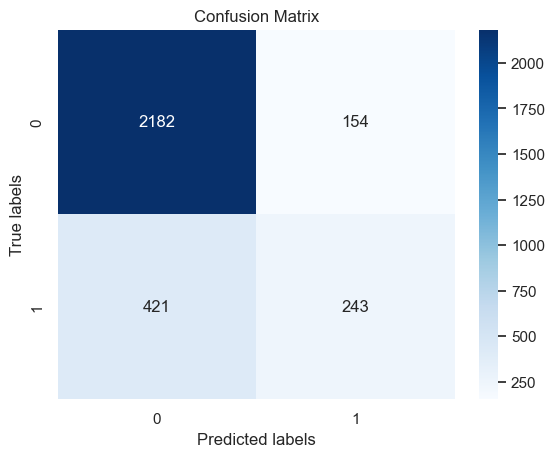

In [217]:
model = NB_train(df_train_scaled)
model_test(model, df_test_scaled)

Best hyperparameters: {'var_smoothing': 1e-30}
Best Model :  GaussianNB(var_smoothing=1e-30)
Training Accuracy : 89.79794783709262
Training F1 Score : 89.68410972217538
Validation Accuracy : 89.7934359068665
Validation F1 Score : 89.90873521349606


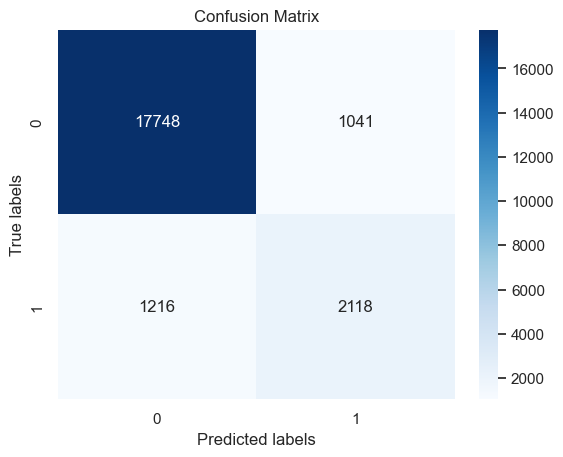

Testing Accuracy : 81.73333333333333
Testing F1 Score : 80.31436350571846


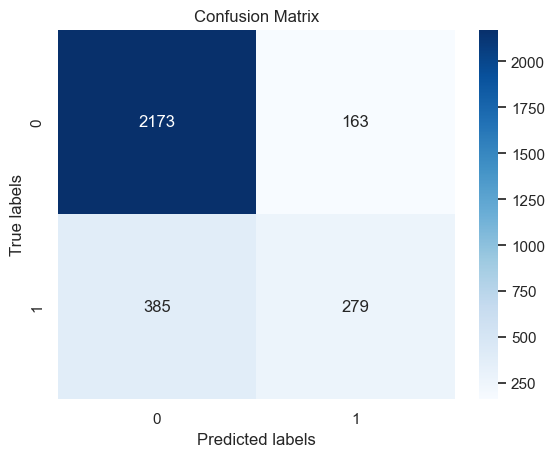

In [218]:
model, lda = NB_train(df_train_scaled, LDA_flag=True)
model_test(model, df_test_scaled, lda=lda, LDA_flag=True)

Perceptron

In [219]:
def Perceptron_tuning(dataframe, hyperparameters, LDA_flag = False, n_comp = None):
    '''
    Perform hyperparameter tuning for Naive Bayes classifier and return the final trained model.
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    if LDA_flag == True:
        lda = LinearDiscriminantAnalysis(n_components=n_comp)
        lda.fit(data, labels)
        data = lda.transform(data)
    model = Perceptron(random_state=42, n_jobs=-1)
    gridsearch = GridSearchCV(estimator=model, param_grid=hyperparameters, cv=5, n_jobs=-1)
    gridsearch.fit(data, labels)
    print("Best hyperparameters:", gridsearch.best_params_)
    print("Best Model : ",gridsearch.best_estimator_)
    model = gridsearch.best_estimator_
    if LDA_flag == True:
        return model, lda
    return model

In [220]:
def Perceptron_train(dataframe, LDA_flag = False, n_comp = None):
    '''
    Training function for random forest classifier
    '''
    data = dataframe.drop(['default payment next month'], axis = 1)
    labels = dataframe['default payment next month'].copy(deep = True)
    hyperparameters = {'penalty': ['l1', 'l2', 'elasticnet'],
                    'alpha': [0.0001, 0.001, 0.01, 0.1],
                    'max_iter': [100, 500, 1000]}
    if LDA_flag == True:
        best_model, lda = Perceptron_tuning(dataframe, hyperparameters, LDA_flag, n_comp)
        data = lda.transform(data)
    else:
        best_model = Perceptron_tuning(dataframe, hyperparameters)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    if LDA_flag == True:
        data = data
    else:
        data = data.to_numpy()
    labels = labels.to_numpy()
    val_acc = 0
    val_f1 = 0
    for train_index, val_index in kf.split(data):
        X_train, X_val = data[train_index], data[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        best_model.fit(X_train, y_train)
        v_acc, v_f1 = performance_metrics(y_val, best_model.predict(X_val))
        val_acc += v_acc
        val_f1 += v_f1
    train_pred = best_model.predict(data)
    train_acc, train_f1 = performance_metrics(train_pred, labels)
    print(f"Training Accuracy : {train_acc*100}")
    print(f"Training F1 Score : {train_f1*100}")
    print(f"Validation Accuracy : {(val_acc/5)*100}")
    print(f"Validation F1 Score : {(val_f1/5)*100}")
    display_confusion_matrix(train_pred, labels)
    if LDA_flag == True:
        return best_model, lda
    return best_model

Best hyperparameters: {'alpha': 0.001, 'max_iter': 100, 'penalty': 'l1'}
Best Model :  Perceptron(alpha=0.001, max_iter=100, n_jobs=-1, penalty='l1', random_state=42)
Training Accuracy : 88.73570492247886
Training F1 Score : 88.64313375031813
Validation Accuracy : 87.14911371972087
Validation F1 Score : 86.94263481122523


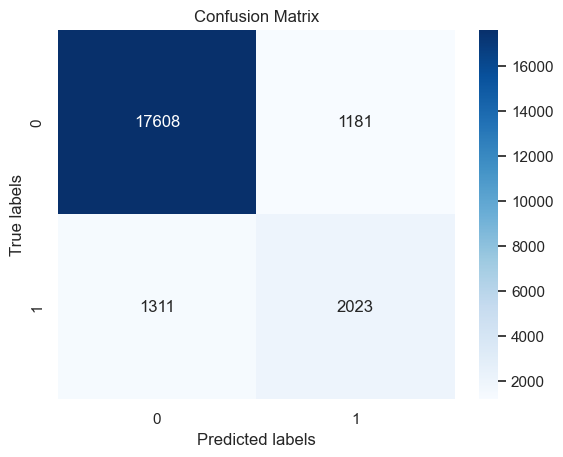

d:\anaconda3\envs\EE559\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but Perceptron was fitted without feature names
  warnings.warn(


Testing Accuracy : 80.16666666666666
Testing F1 Score : 78.8738017515503


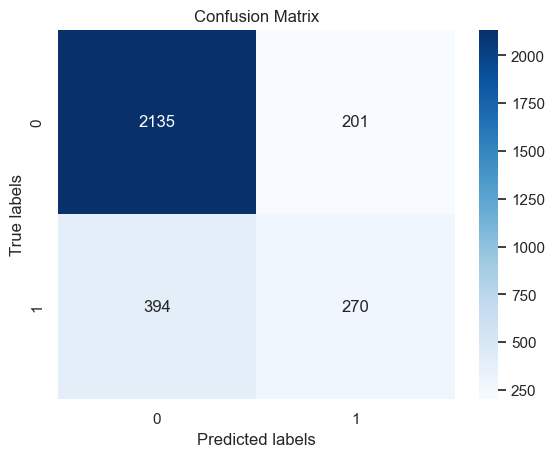

In [221]:
model = Perceptron_train(df_train_scaled)
model_test(model, df_test_scaled)

Best hyperparameters: {'alpha': 0.0001, 'max_iter': 100, 'penalty': 'l1'}
Best Model :  Perceptron(max_iter=100, n_jobs=-1, penalty='l1', random_state=42)
Training Accuracy : 89.50865614970844
Training F1 Score : 88.52910880224304
Validation Accuracy : 89.43177021076613
Validation F1 Score : 89.86588024139742


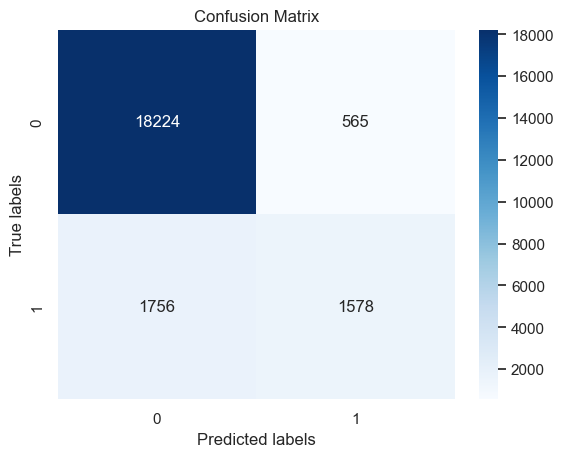

Testing Accuracy : 81.26666666666667
Testing F1 Score : 78.6566733902342


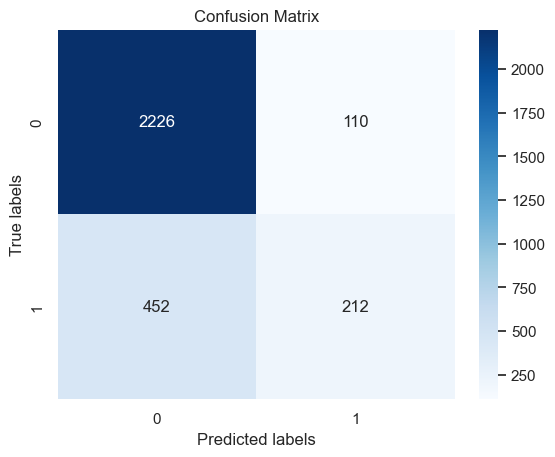

In [222]:
model, lda = Perceptron_train(df_train_scaled, LDA_flag=True)
model_test(model, df_test_scaled, lda=lda, LDA_flag=True)